In [2]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import Base: show

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260
┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1260
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [148]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min = add!(model, datavar(:xt_min, NormalMeanVariance{Float64}))
    xt     = add!(model, simplerandomvar(:xt))
    
    zt = add!(model, datavar(:zt, NormalMeanVariance{Float64}))
    kt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    ωt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    
    gcv = add!(model, GCVNode())
    
    connect!(gcv, :x, xt_min, 1)
    connect!(gcv, :y, xt, 1)
    connect!(gcv, :z, zt, 1)
    connect!(gcv, :κ, kt, 1)
    connect!(gcv, :ω, ωt, 1)
    
    add_noise = add!(model, AdditionNode())
    noise     = add!(model, constvar(:noise, NormalMeanVariance(0.0, 200.0)))
    
    connect!(add_noise, :in1, xt, 2)
    connect!(add_noise, :in2, noise, 1)
    
    y = add!(model, datavar(:y, Float64))
    
    connect!(add_noise, :out, y, 1)
    
    activate!(model, gcv)
    activate!(model, add_noise)
    
    # Linking
    link(zt, getmarginal(zt))
    link(kt, getmarginal(kt))
    link(ωt, getmarginal(ωt))
    
    # Initial messages
    update!(zt, NormalMeanVariance(0.0, 1.0))
    update!(kt, NormalMeanVariance(0.0, 1.0))
    update!(ωt, NormalMeanVariance(0.0, 1.0))
    
    # Prior marginals
    # setmarginal!(gcv, :xy, MvNormal()) ?
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 1.0))
    setmarginal!(gcv, :κ, NormalMeanVariance(0.0, 1.0))
    setmarginal!(gcv, :ω, NormalMeanVariance(0.0, 1.0))

    link(xt_min, getmarginal(xt))
    
    update!(xt_min, NormalMeanVariance(0.0, 1.0))
    
    mk = Vector{NormalMeanVariance}()
    mw = Vector{NormalMeanVariance}()
    mz = Vector{NormalMeanVariance}()
    mx = Vector{NormalMeanVariance}()

    s_mk = subscribe!(getmarginal(kt) |> enumerate(), (t) -> push!(mk, getdata(t[2])))
    s_mw = subscribe!(getmarginal(ωt) |> enumerate(), (t) -> push!(mw, getdata(t[2])))
    s_mz = subscribe!(getmarginal(zt) |> enumerate(), (t) -> push!(mz, getdata(t[2])))
    s_mx = subscribe!(getmarginal(xt) |> enumerate(), (t) -> push!(mx, getdata(t[2])))
    
    for i in 1:n
        for _ in 1:iters
            update!(y, data[i])
        end
    end
    
    unsubscribe!(s_mk)
    unsubscribe!(s_mw)
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    
    return mx, mk, mw, mz
end

hgf (generic function with 1 method)

In [162]:
n = 2000
iters = 15

real_k = 3.0
real_w = -4.0

z_mean     = 25.0
z_variance = 0.01

obs_noise = 200.0

z = rand(Normal(z_mean, sqrt(z_variance)), (n,))
v = map(d -> real_k * d + real_w, z)
y = Vector{Float64}(undef, n)

y_prev = 0.0

for i in 1:n
    y[i] = rand(Normal(y_prev, v[i]))
    y_prev = y[i]
end

data = map(d -> d + rand(Normal(0, sqrt(obs_noise))), y);

In [163]:
@time mx, mk, mw, mz = hgf(n, iters, data);

  2.625819 seconds (18.03 M allocations: 927.812 MiB, 20.94% gc time)


In [167]:
mw

149997-element Array{NormalMeanVariance,1}:
 NormalMeanVariance{Float64}(0.0, 1.0)
 NormalMeanVariance{Float64}(-0.10161929480900178, 0.7336472337345235)
 NormalMeanVariance{Float64}(-0.19010955424723774, 0.5812414317288416)
 NormalMeanVariance{Float64}(-0.2580572115062787, 0.4790273062993379)
 NormalMeanVariance{Float64}(-0.3125738806311061, 0.40622081661828674)
 NormalMeanVariance{Float64}(-0.3575663716320359, 0.35191364211521947)
 NormalMeanVariance{Float64}(-0.32153994283228304, 0.2916364900594773)
 NormalMeanVariance{Float64}(-0.3010636945478343, 0.2506916571960914)
 NormalMeanVariance{Float64}(-0.28771306054274237, 0.2205204440361706)
 NormalMeanVariance{Float64}(-0.2788072708832257, 0.19726372481410895)
 NormalMeanVariance{Float64}(-0.2727410797625049, 0.17871401286336924)
 NormalMeanVariance{Float64}(-0.26352532392828043, 0.16278699011974956)
 NormalMeanVariance{Float64}(-0.2567603513630977, 0.14967359746108258)
 ⋮
 NormalMeanVariance{Float64}(0.5460440209768582, 1.212562407171

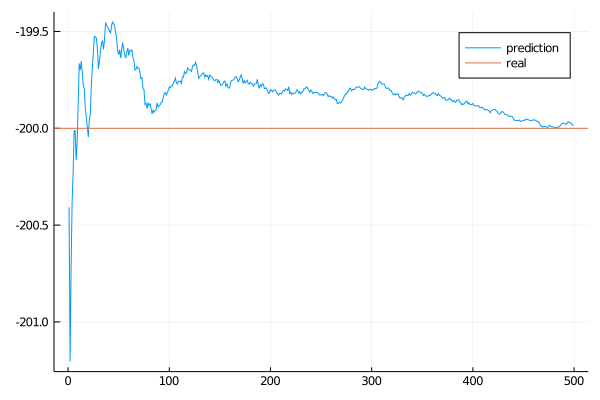

In [26]:
plot(ma[2:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

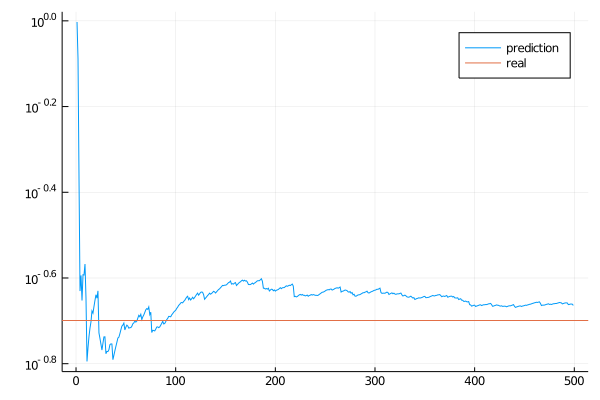

In [27]:
plot(pa[2:end], label = :prediction, yscale = :log10)
plot!([ realprecision ], seriestype=:hline, label = :real)

In [11]:
r = MvNormal([ 0.0, 0.0 ], [ 2.0 0.0; 0.0 1.0 ])

FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [2.0 0.0; 0.0 1.0]
)


In [14]:
cov(r)

2×2 Array{Float64,2}:
 2.0  0.0
 0.0  1.0

In [15]:
?MvNormal

search: MvNormal MvNormalCanon MvNormalKnownCov MvLogNormal AbstractMvNormal



```
MvNormal
```

Generally, users don't have to worry about these internal details. We provide a common constructor `MvNormal`, which will construct a distribution of appropriate type depending on the input arguments.

```
MvNormal(sig)
```

Construct a multivariate normal distribution with zero mean and covariance represented by `sig`.

```
MvNormal(mu, sig)
```

Construct a multivariate normal distribution with mean `mu` and covariance represented by `sig`.

```
MvNormal(d, sig)
```

Construct a multivariate normal distribution of dimension `d`, with zero mean, and an isotropic covariance matrix corresponding `abs2(sig)*I`.

# Arguments

  * `mu::Vector{T<:Real}`: The mean vector.
  * `d::Real`: dimension of distribution.
  * `sig`: The covariance, which can in of either of the following forms (with `T<:Real`):

    1. subtype of `AbstractPDMat`,
    2. symmetric matrix of type `Matrix{T}`,
    3. vector of type `Vector{T}`: indicating a diagonal covariance as `diagm(abs2(sig))`,
    4. real-valued number: indicating an isotropic covariance matrix corresponding `abs2(sig) * I`.

**Note:** The constructor will choose an appropriate covariance form internally, so that special structure of the covariance can be exploited.


In [22]:
g = GCVNode()

FactorNode{Type{ReactiveMP.GCV},5,Tuple{Tuple{Int64,Int64},Tuple{Int64},Tuple{Int64},Tuple{Int64}},ReactiveMP.FactorNodeLocalMarginals{4}}(ReactiveMP.GCV, (x, y, z, κ, ω), ((1, 2), (3,), (4,), (5,)), ReactiveMP.FactorNodeLocalMarginals{4}(((:xy, Base.RefValue{Union{Nothing, ReactiveMP.MarginalObservable}}(nothing)), (:z, Base.RefValue{Union{Nothing, ReactiveMP.MarginalObservable}}(nothing)), (:κ, Base.RefValue{Union{Nothing, ReactiveMP.MarginalObservable}}(nothing)), (:ω, Base.RefValue{Union{Nothing, ReactiveMP.MarginalObservable}}(nothing)))))

In [23]:
clusterindex(g, :x)

1

In [16]:
?all

search: all all! allocs allunique @allocated call_operator!



```
all(itr) -> Bool
```

Test whether all elements of a boolean collection are `true`, returning `false` as soon as the first `false` value in `itr` is encountered (short-circuiting).

If the input contains [`missing`](@ref) values, return `missing` if all non-missing values are `true` (or equivalently, if the input contains no `false` value), following [three-valued logic](https://en.wikipedia.org/wiki/Three-valued_logic).

# Examples

```jldoctest
julia> a = [true,false,false,true]
4-element Array{Bool,1}:
 1
 0
 0
 1

julia> all(a)
false

julia> all((println(i); v) for (i, v) in enumerate(a))
1
2
false

julia> all([missing, false])
false

julia> all([true, missing])
missing
```

---

```
all(p, itr) -> Bool
```

Determine whether predicate `p` returns `true` for all elements of `itr`, returning `false` as soon as the first item in `itr` for which `p` returns `false` is encountered (short-circuiting).

If the input contains [`missing`](@ref) values, return `missing` if all non-missing values are `true` (or equivalently, if the input contains no `false` value), following [three-valued logic](https://en.wikipedia.org/wiki/Three-valued_logic).

# Examples

```jldoctest
julia> all(i->(4<=i<=6), [4,5,6])
true

julia> all(i -> (println(i); i < 3), 1:10)
1
2
3
false

julia> all(i -> i > 0, [1, missing])
missing

julia> all(i -> i > 0, [-1, missing])
false

julia> all(i -> i > 0, [1, 2])
true
```

---

```
all(A; dims)
```

Test whether all values along the given dimensions of an array are `true`.

# Examples

```jldoctest
julia> A = [true false; true true]
2×2 Array{Bool,2}:
 1  0
 1  1

julia> all(A, dims=1)
1×2 Array{Bool,2}:
 1  0

julia> all(A, dims=2)
2×1 Array{Bool,2}:
 0
 1
```


In [21]:
@btime clusterindex($g, (:x, :y))

  352.105 ns (7 allocations: 272 bytes)


1

In [51]:
using LinearAlgebra

In [52]:
?Hermitian

search: Hermitian ishermitian



```
Hermitian(A, uplo=:U)
```

Construct a `Hermitian` view of the upper (if `uplo = :U`) or lower (if `uplo = :L`) triangle of the matrix `A`.

# Examples

```jldoctest
julia> A = [1 0 2+2im 0 3-3im; 0 4 0 5 0; 6-6im 0 7 0 8+8im; 0 9 0 1 0; 2+2im 0 3-3im 0 4];

julia> Hupper = Hermitian(A)
5×5 Hermitian{Complex{Int64},Array{Complex{Int64},2}}:
 1+0im  0+0im  2+2im  0+0im  3-3im
 0+0im  4+0im  0+0im  5+0im  0+0im
 2-2im  0+0im  7+0im  0+0im  8+8im
 0+0im  5+0im  0+0im  1+0im  0+0im
 3+3im  0+0im  8-8im  0+0im  4+0im

julia> Hlower = Hermitian(A, :L)
5×5 Hermitian{Complex{Int64},Array{Complex{Int64},2}}:
 1+0im  0+0im  6+6im  0+0im  2-2im
 0+0im  4+0im  0+0im  9+0im  0+0im
 6-6im  0+0im  7+0im  0+0im  3+3im
 0+0im  9+0im  0+0im  1+0im  0+0im
 2+2im  0+0im  3-3im  0+0im  4+0im
```

Note that `Hupper` will not be equal to `Hlower` unless `A` is itself Hermitian (e.g. if `A == adjoint(A)`).

All non-real parts of the diagonal will be ignored.

```julia
Hermitian(fill(complex(1,1), 1, 1)) == fill(1, 1, 1)
```


In [56]:
dump(MvNormal([ 0.0, 0.0 ]))

MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},FillArrays.Zeros{Float64,1,Tuple{Base.OneTo{Int64}}}}
  μ: FillArrays.Zeros{Float64,1,Tuple{Base.OneTo{Int64}}}
    axes: Tuple{Base.OneTo{Int64}}
      1: Base.OneTo{Int64}
        stop: Int64 2
  Σ: PDMats.PDiagMat{Float64,Array{Float64,1}}
    dim: Int64 2
    diag: Array{Float64}((2,)) [0.0, 0.0]
    inv_diag: Array{Float64}((2,)) [Inf, Inf]


In [1]:
import PDMats

┌ Info: Precompiling PDMats [90014a1f-27ba-587c-ab20-58faa44d9150]
└ @ Base loading.jl:1260


In [50]:
W = Matrix(cov(MvNormalMeanCovariance([0.0, 0.0], inv(PDMats.PDMat([ 1.0 0.0; 0.0 2.0 ])))))

2×2 Array{Float64,2}:
  1.0  -0.0
 -0.0   0.5

In [41]:
W[1]

MethodError: MethodError: no method matching getindex(::PDMats.PDMat{Float64,Array{Float64,2}}, ::Int64)

In [8]:
?Distributions.product_distribution

```
product_distribution(dists::AbstractVector{<:UnivariateDistribution})
```

Creates a multivariate product distribution `P` from a vector of univariate distributions. Fallback is the `Product constructor`, but specialized methods can be defined for distributions with a special multivariate product.

---

```
product_distribution(dists::AbstractVector{<:Normal})
```

Computes the multivariate Normal distribution obtained by stacking the univariate normal distributions. The result is a multivariate Gaussian with a diagonal covariance matrix.


In [49]:
dump(MvNormal([ 0.0, 0.0 ], [ 1.0 0.0 ; 0.0 1.0 ]))

MvNormal{Float64,PDMats.PDMat{Float64,Array{Float64,2}},Array{Float64,1}}
  μ: Array{Float64}((2,)) [0.0, 0.0]
  Σ: PDMats.PDMat{Float64,Array{Float64,2}}
    dim: Int64 2
    mat: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
    chol: LinearAlgebra.Cholesky{Float64,Array{Float64,2}}
      factors: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
      uplo: Char 'U'
      info: Int64 0


In [66]:
typeof((0, 2))

Tuple{Int64,Int64}

In [69]:
@btime prod((1,))

  0.036 ns (0 allocations: 0 bytes)


1

In [74]:
collect(Iterators.product(Iterators.repeated([ 1, 2 ], 1)...))[1][1] * 2

2

In [75]:
similar(1)

MethodError: MethodError: no method matching similar(::Int64)
Closest candidates are:
  similar(!Matched::ZMQ.Message, !Matched::Type{T}, !Matched::Tuple{Vararg{Int64,N}} where N) where T at /Users/bvdmitri/.julia/packages/ZMQ/R3wSD/src/message.jl:93
  similar(!Matched::JuliaInterpreter.Compiled, !Matched::Any) at /Users/bvdmitri/.julia/packages/JuliaInterpreter/RmxVj/src/types.jl:7
  similar(!Matched::BenchmarkGroup) at /Users/bvdmitri/.julia/packages/BenchmarkTools/eCEpo/src/groups.jl:24
  ...

In [78]:
similar([], Int, (1,))

1-element Array{Int64,1}:
 4966055936

In [90]:
NormalMeanVariance(0.0, 2.0)

NormalMeanVariance{Float64}(0.0, 2.0)

In [101]:
@btime ReactiveMP.approximate_meancov(ReactiveMP.ghcubature(16), x -> 1, NormalMeanVariance(-10.0, 2.0))

  22.366 μs (61 allocations: 12.28 KiB)


(-10.000000000000004, 2.0000000000000253)

In [96]:
using ReactiveMP